

 # 基于傅里叶神经算子(FNO)训练Darcy-Flow(达西流)模型



 本教程演示在小型Darcy-Flow数据集上训练傅里叶神经算子(FNO)的完整流程：

 1. 加载并预处理Darcy-Flow数据集（渗透率场作为输入，压力场作为输出）

 2. 构建FNO模型架构

 3. 配置训练组件（优化器、学习率调度器、损失函数）

 4. 训练模型

 5. 评估模型预测效果，并验证FNO的零样本超分辨率能力



 注意：本教程使用的数据集远小于实际应用场景（仅用于CPU快速演示）， 实际部署时通常会在单/多GPU上使用更大的数据集训练。 FNO的核心优势是**分辨率不变性**——无需重新训练即可在不同分辨率下预测， 这一点会在零样本超分辨率部分验证。


 ## 导入依赖库

 从neuralop库导入训练FNO所需的核心模块



In [1]:
# 导入PyTorch核心库（张量计算、自动微分等）
import torch
# 导入绘图库（用于可视化预测结果）
import matplotlib.pyplot as plt
# 导入系统库（用于强制刷新输出）
import sys
# 从neuralop导入FNO模型核心类
from neuralop.models import FNO
# 从neuralop导入训练器（封装训练循环、评估逻辑）
from neuralop import Trainer
# 从neuralop导入AdamW优化器（带权重衰减的Adam）
from neuralop.training import AdamW
# 加载小型Darcy-Flow数据集（内置数据集）
from neuralop.data.datasets import load_darcy_flow_small
# 导入模型参数统计工具
from neuralop.utils import count_model_params
# 导入损失函数（Lp损失和H1损失，适用于PDE问题）
from neuralop import LpLoss, H1Loss
import os
# 设置训练设备：CPU（本教程为简化演示使用CPU）
device = "cpu"


尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages
尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages






 ## 加载Darcy-Flow数据集

 Darcy-Flow数据集包含：

 - 输入：渗透率场（permeability fields）→ 描述介质的渗透特性

 - 输出：压力场（pressure fields）→ 达西流在介质中的压力分布

 我们加载包含多分辨率的小型数据集，用于训练和测试



In [2]:
# 加载小型Darcy-Flow数据集
# 参数说明：
# n_train: 训练样本数量（1000个）
# batch_size: 训练批大小（每次迭代喂入64个样本）
# n_tests: 测试样本数量列表（16分辨率用100个，32分辨率用50个）
# test_resolutions: 测试数据的分辨率列表（16x16和32x32）
# test_batch_sizes: 测试批大小列表（对应分辨率各用32个）
train_loader, test_loaders, data_processor = load_darcy_flow_small(
    n_train=1000,
    batch_size=64,
    n_tests=[100, 50],
    test_resolutions=[16, 32],
    test_batch_sizes=[32, 32],
)
# 将数据处理器移到指定设备（CPU），确保数据和模型在同一设备
data_processor = data_processor.to(device)


Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


 ## 构建FNO模型

 FNO（傅里叶神经算子）是基于傅里叶变换的神经算子， 核心优势是能高效学习函数空间到函数空间的映射（适用于PDE求解）



In [3]:
# 初始化FNO模型
# 参数说明：
# n_modes: 傅里叶模式数（(8,8)表示在x/y维度各取8个傅里叶模式）→ 控制模型对高频信息的捕捉能力
# in_channels: 输入通道数（1→渗透率场是单通道二维数据）
# out_channels: 输出通道数（1→压力场是单通道二维数据）
# hidden_channels: 隐藏层通道数（24→模型特征维度）
# projection_channel_ratio: 投影通道比率（2→控制投影层的通道数）
model = FNO(
    n_modes=(8, 8),
    in_channels=1,
    out_channels=1,
    hidden_channels=24,
    projection_channel_ratio=2,
)
# 将模型移到指定设备（CPU）
model = model.to(device)

# 统计并打印模型参数数量（评估模型复杂度）
n_params = count_model_params(model)
print(f"\n当前FNO模型的参数总量：{n_params} 个。")
# 强制刷新标准输出（确保参数数量立即打印）
sys.stdout.flush()

# 如果配置文件不存在，则创建一个并写入模型参数数量和配置
if not os.path.exists("FNO_model_config.txt"):
    with open ("FNO_model_config.txt", "w") as f:
        f.write(f"当前FNO模型的参数总量：{n_params} 个。\n")
        f.write("\n### 模型配置 ###\n")
        print(model, file=f)


当前FNO模型的参数总量：191881 个。






 ## 配置优化器和学习率调度器

 - 优化器：AdamW（带权重衰减的Adam，防止过拟合）

 - 学习率调度器：余弦退火（CosineAnnealingLR）→ 动态调整学习率，提升训练稳定性



In [4]:
# 初始化AdamW优化器
# 参数说明：
# model.parameters(): 待优化的模型参数
# lr: 初始学习率（1e-2）
# weight_decay: 权重衰减系数（1e-4）→ 正则化，防止过拟合
optimizer = AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)

# 初始化余弦退火学习率调度器
# 参数说明：
# optimizer: 关联的优化器
# T_max: 学习率周期（30轮）→ 每30轮学习率完成一次余弦周期变化
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
print("\n### 优化器配置 ###\n", optimizer)
print("\n### 学习率调度器配置 ###\n", scheduler)


### 优化器配置 ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.01
    lr: 0.01
    weight_decay: 0.0001
)

### 学习率调度器配置 ###






 ## 定义损失函数

 针对PDE（偏微分方程）问题，选择适合的损失函数：

 - H1损失：同时惩罚函数值误差和梯度误差（更适合PDE求解，因为PDE的解对梯度敏感）

 - L2损失（LpLoss(d=2,p=2)）：仅惩罚函数值误差（用于评估）



In [5]:
# 定义L2损失（2维，p=2）→ 即均方误差（MSE），用于评估模型预测值与真实值的差距
l2loss = LpLoss(d=2, p=2)
# 定义H1损失（2维）→ 包含L2损失 + 梯度的L2损失，更适合PDE训练
h1loss = H1Loss(d=2)

# 训练时使用H1损失
train_loss = h1loss
# 评估时同时使用H1和L2损失（多维度评估模型性能）
eval_losses = {"h1": h1loss, "l2": l2loss}

print("\n### 损失函数配置 ###")
print(f"\n * 训练损失: {train_loss}")
print(f"\n * 评估损失: {eval_losses}")
sys.stdout.flush()


### 损失函数配置 ###

 * 训练损失: <neuralop.losses.data_losses.H1Loss object at 0x0000018E599AC230>

 * 评估损失: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x0000018E599AC230>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x0000018E5982AA20>}




 ## 创建训练器

 neuralop的Trainer类封装了完整的训练逻辑：

 - 前向传播、反向传播、参数更新

 - 自动评估、日志记录、断点续训等



In [6]:
# 初始化训练器
# 参数说明：
# model: 待训练的FNO模型
# n_epochs: 训练总轮数（15轮，简化演示）
# device: 训练设备（CPU）
# data_processor: 数据处理器（预处理/后处理数据）
# wandb_log: 是否使用Weights & Biases日志工具（关闭，简化演示）
# eval_interval: 评估间隔（每5轮评估一次模型）
# use_distributed: 是否使用分布式训练（关闭，单CPU训练）
# verbose: 是否打印训练进度（开启，方便查看训练过程）
trainer = Trainer(
    model=model,
    n_epochs=15,
    device=device,
    data_processor=data_processor,
    wandb_log=False,
    eval_interval=5,
    use_distributed=False,
    verbose=True,
)




 ## 启动模型训练

 训练器会自动执行以下流程：

 1. 从训练加载器读取批次数据

 2. 前向传播：通过FNO模型得到预测值

 3. 计算H1损失（训练损失）

 4. 反向传播：计算梯度并更新模型参数

 5. 每5轮在测试集上评估（计算H1/L2损失）

 6. 学习率调度器按周期调整学习率



In [7]:
trainer.train(
    train_loader=train_loader,       # 训练数据加载器
    test_loaders=test_loaders,       # 测试数据加载器（多分辨率）
    optimizer=optimizer,             # 优化器
    scheduler=scheduler,             # 学习率调度器
    regularizer=False,               # 是否使用正则化（关闭）
    training_loss=train_loss,        # 训练损失函数（H1Loss）
    eval_losses=eval_losses,         # 评估损失函数（H1+L2）
)


Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].


c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1786: UserWarning: FNO.forward() received unexpected keyword arguments: ['y']. These arguments will be ignored.
  return forward_call(*args, **kwargs)
c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\training\trainer.py:536: UserWarning: H1Loss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  loss += training_loss(out, **sample)


Raw outputs of shape torch.Size([64, 1, 16, 16])
[0] time=3.87, avg_loss=0.7333, train_err=45.8290


c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\training\trainer.py:581: UserWarning: LpLoss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  val_loss = loss(out, **sample)


Eval: 16_h1=0.5203, 16_l2=0.3603, 32_h1=0.6274, 32_l2=0.3712
[5] time=3.74, avg_loss=0.2532, train_err=15.8223
Eval: 16_h1=0.2626, 16_l2=0.1800, 32_h1=0.3730, 32_l2=0.1948
[10] time=3.57, avg_loss=0.2043, train_err=12.7659
Eval: 16_h1=0.2232, 16_l2=0.1521, 32_h1=0.3440, 32_l2=0.1720


{'train_err': 11.182661890983582,
 'avg_loss': 0.1789225902557373,
 'avg_lasso_loss': None,
 'epoch_train_time': 3.478553799999986}



 ## 可视化模型预测结果

 对比展示：

 1. 输入（渗透率场）

 2. 真实输出（压力场）

 3. 模型预测输出（压力场）

 选取16x16分辨率的测试样本（模型训练的分辨率）



C:\Users\MR\AppData\Local\Temp\ipykernel_17344\384631773.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


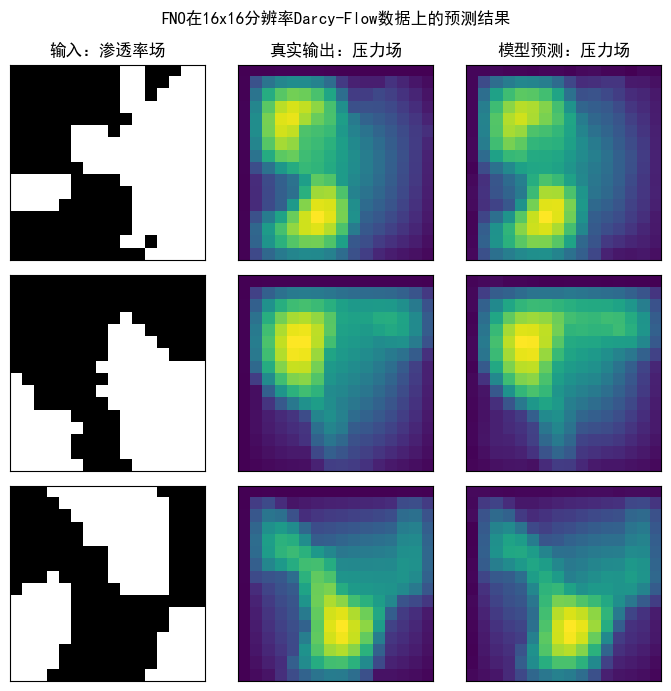

In [8]:
# 获取16x16分辨率的测试数据集（test_loaders字典按分辨率索引）
test_samples = test_loaders[16].dataset

plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号

# 创建绘图画布（7x7英寸）
fig = plt.figure(figsize=(7, 7))
# 可视化前3个测试样本
for index in range(3):
    # 获取第index个测试样本
    data = test_samples[index]
    # 预处理样本（非批量模式，batched=False）
    data = data_processor.preprocess(data, batched=False)

    # 提取输入：渗透率场（x）
    x = data["x"]
    # 提取真实输出：压力场（y）
    y = data["y"]
    # 模型预测：添加batch维度（模型期望输入为[batch, channel, H, W]），再执行前向传播
    out = model(x.unsqueeze(0))

    # 绘制输入（渗透率场）
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    ax.imshow(x[0], cmap="gray")  # x[0]取通道维度，显示二维数据
    if index == 0:
        ax.set_title("输入：渗透率场")  # 仅第一个样本设置标题
    plt.xticks([], [])  # 隐藏x轴刻度
    plt.yticks([], [])  # 隐藏y轴刻度

    # 绘制真实输出（压力场）
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    ax.imshow(y.squeeze())  # 挤压维度，显示二维数据
    if index == 0:
        ax.set_title("真实输出：压力场")
    plt.xticks([], [])
    plt.yticks([], [])

    # 绘制模型预测输出（压力场）
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    # detach()分离张量（停止梯度计算），转numpy用于绘图
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title("模型预测：压力场")
    plt.xticks([], [])
    plt.yticks([], [])

# 设置总标题
fig.suptitle("FNO在16x16分辨率Darcy-Flow数据上的预测结果", y=0.98)
# 调整子图间距
plt.tight_layout()
# 显示图像
fig.show()




 ## 零样本超分辨率评估

 FNO的核心优势：**分辨率不变性**

 - 模型仅在16x16分辨率数据上训练

 - 无需重新训练/微调，直接在32x32高分辨率数据上预测

 验证模型对未见过的高分辨率数据的泛化能力



C:\Users\MR\AppData\Local\Temp\ipykernel_17344\3090718753.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


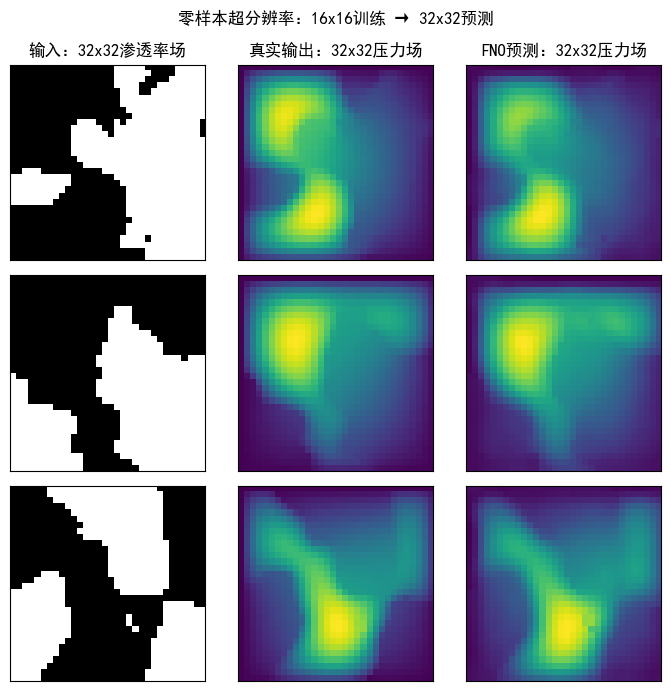

In [9]:
# 获取32x32分辨率的测试数据集（模型未在该分辨率训练过）
test_samples = test_loaders[32].dataset

# 创建绘图画布
fig = plt.figure(figsize=(7, 7))
# 可视化前3个高分辨率测试样本
for index in range(3):
    data = test_samples[index]
    # 预处理高分辨率样本
    data = data_processor.preprocess(data, batched=False)

    # 提取32x32分辨率输入（渗透率场）
    x = data["x"]
    # 提取32x32分辨率真实输出（压力场）
    y = data["y"]
    # 模型直接预测（无需修改，FNO自动适配分辨率）
    out = model(x.unsqueeze(0))

    # 绘制32x32分辨率输入
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    ax.imshow(x[0], cmap="gray")
    if index == 0:
        ax.set_title("输入：32x32渗透率场")
    plt.xticks([], [])
    plt.yticks([], [])

    # 绘制32x32分辨率真实输出
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title("真实输出：32x32压力场")
    plt.xticks([], [])
    plt.yticks([], [])

    # 绘制32x32分辨率模型预测（零样本）
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title("FNO预测：32x32压力场")
    plt.xticks([], [])
    plt.yticks([], [])

# 设置总标题
fig.suptitle("零样本超分辨率：16x16训练 → 32x32预测", y=0.98)
plt.tight_layout()
fig.show()






 ## 零样本超分辨率说明

 1. 模型仅在16x16分辨率数据上训练，未见过32x32数据

 2. FNO通过傅里叶变换学习**函数空间的映射关系**（而非固定分辨率的像素映射），因此能适配不同分辨率

 3. 高分辨率预测可能有噪声（因未见过高频信息），但验证了FNO的分辨率不变性核心优势



 实际应用中，会在训练过程中跟踪多分辨率的评估指标，以量化零样本超分辨率性能。



